In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util.plot import plot_cdf
from util.consts import balance_size_bins, balance_size_bins_label
from util.plot import color_list
import json
import os
from collections import defaultdict


In [2]:
def compute_active_flows(fats, fcts):
    num_flows = len(fats)
    result = np.zeros(num_flows, dtype=int)
    
    finish_times = fats + fcts
    
    for i in range(num_flows):
        flow_start = fats[i]
        flow_end = finish_times[i]
        
        active_flows = np.where((fats < flow_end) & (finish_times > flow_start) & (np.arange(num_flows) != i))[0]
        result[i] = len(active_flows)
    
    return result

Predicted Completion Times: (2000,)


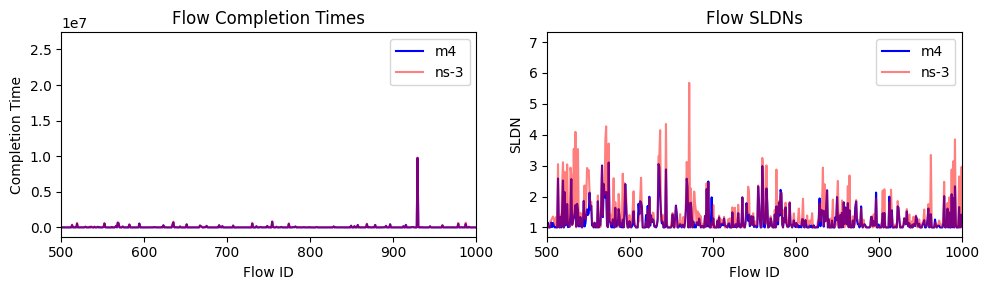

Mean relative error of SLDN per flow: 9.72%


NameError: name '_fontsize' is not defined

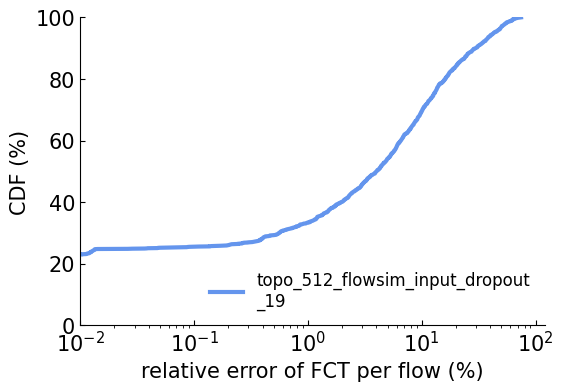

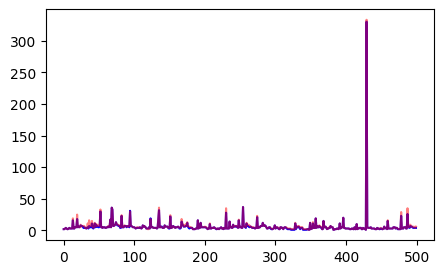

In [38]:
# Load the data from the .npz file
max_inflight_flows=0
scenario_idx=3
# model_instance = "link_batch"
# model_instance = "topo_512_remainsize"
model_instance = "topo_512_flowsim_input_dropout_19"
# model_instance = "topo_64"
# model_instance = "topo_512_remainsize_link"
# model_instance = "flowsim"
empirical_str = "_empirical"
# empirical_str=''
x_min=500
x_max=1000

fats=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/data_empirical/3/ns3/fat.npy')
fcts=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/data_empirical/3/ns3/fct_topology_flows_dctcp.npy')


data = np.load(f'./res/{model_instance}{empirical_str}.npz')
fct = data['fct']
sldn = data['sldn']

data_flowsim = np.load(f'./res/flowsim{empirical_str}.npz')
fct_flowsim = data_flowsim['fct']
sldn_flowsim = data_flowsim['sldn']

# Extract the data
predicted_completion_times = fct[scenario_idx, :, 0].flatten()
actual_completion_times = fct[scenario_idx, :, 1].flatten()
# predicted_sldns = sldn[scenario_idx, :, 0].flatten()-sldn_flowsim[scenario_idx, :1000, 0].flatten()
# actual_sldns = sldn[scenario_idx, :, 1].flatten()-sldn_flowsim[scenario_idx, :1000, 0].flatten()
predicted_sldns = sldn[scenario_idx, :, 0].flatten()
actual_sldns = sldn[scenario_idx, :, 1].flatten()

fid_rank = compute_active_flows(fats, actual_completion_times)
fid_rank_m4 = compute_active_flows(fats, predicted_completion_times)

predicted_sldns[predicted_sldns<1]=1
actual_sldns[actual_sldns<1]=1

print('Predicted Completion Times:', predicted_completion_times.shape)
# Plotting the completion times
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(predicted_completion_times, label='m4', color='b')
plt.plot(actual_completion_times, label='ns-3', color='r',alpha=0.5)
plt.xlabel('Flow ID')
plt.ylabel('Completion Time')
plt.title('Flow Completion Times')
plt.legend()
plt.xlim(x_min, x_max)

# Plotting the SLDNs
plt.subplot(1, 2, 2)
plt.plot(predicted_sldns, label='m4', color='b')
plt.plot(actual_sldns, label='ns-3', color='r',alpha=0.5)
plt.xlabel('Flow ID')
plt.ylabel('SLDN')
plt.title('Flow SLDNs')
plt.legend()
# plt.ylim(0, 6)
plt.xlim(x_min, x_max)
# Show the plots
plt.tight_layout()
plt.show()

res_error_sldn = np.abs(predicted_sldns - actual_sldns) / actual_sldns * 100
error_mean=np.mean(res_error_sldn)
print(f"Mean relative error of SLDN per flow: {error_mean:.2f}%")
fig_index=0
plot_cdf(
    [res_error_sldn],
    None,
    [f"{model_instance}"],
    x_label="relative error of FCT per flow (%)",
    log_switch=True,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=1,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=fig_index
)
fig_index=1
fid_rank=fid_rank[x_min:x_max]
fid_rank_m4=fid_rank_m4[x_min:x_max]
plt.figure(figsize=(5, 3))
plt.plot(fid_rank_m4, label='m4', color='b')
plt.plot(fid_rank, label='ns-3', color='r',alpha=0.5)
plt.xlabel('Flow ID',fontsize=_fontsize)
plt.ylabel('# of active flows',fontsize=_fontsize)
plt.xticks(fontsize=_fontsize-2)
plt.yticks(fontsize=_fontsize)
plt.legend(frameon=False,fontsize=_fontsize,loc='upper right')

Predicted Completion Times: (40000,)


(0.0, 20.0)

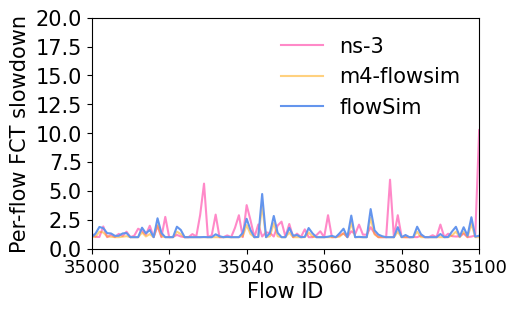

In [29]:
# Load the data from the .npz file
max_inflight_flows=0
scenario_idx=1
# model_instance = "link_batch"
# model_instance = "link_cplusplus"
model_instance = "topo_64_flowsim_input"
# model_instance = "flowsim"
empirical_str = "_empirical"
# empirical_str=''
_fontsize=15

data = np.load(f'./res/test_{model_instance}{empirical_str}.npz')
fct = data['fct']
sldn = data['sldn']
# Extract the data
predicted_completion_times = fct[scenario_idx, :, 0].flatten()
actual_completion_times = fct[scenario_idx, :, 1].flatten()
predicted_sldns = sldn[scenario_idx, :, 0].flatten()
predicted_sldns[predicted_sldns<1]=1
actual_sldns = sldn[scenario_idx, :, 1].flatten()
print('Predicted Completion Times:', predicted_completion_times.shape)

data = np.load(f'./res/test_flowsim{empirical_str}.npz')
fct = data['fct']
sldn = data['sldn']
# Extract the data
predicted_completion_times_flowsim = fct[scenario_idx, :, 0].flatten()
predicted_sldns_flowsim = sldn[scenario_idx, :, 0].flatten()
predicted_sldns_flowsim[predicted_sldns_flowsim<1]=1

# Plotting the completion times
plt.figure(figsize=(5, 3))
plt.plot(actual_sldns, label='ns-3', color=color_list[2],alpha=0.5)
plt.plot(predicted_sldns, label='m4-flowsim', color=color_list[1],alpha=0.5)
plt.plot(predicted_sldns_flowsim, label='flowSim', color=color_list[0])
plt.xlabel('Flow ID',fontsize=_fontsize)
plt.ylabel('Per-flow FCT slowdown',fontsize=_fontsize)
plt.xticks(fontsize=_fontsize-2)
plt.yticks(fontsize=_fontsize)
plt.legend(frameon=False,fontsize=_fontsize,loc='upper right')
plt.xlim(35000, 35100)
plt.ylim(0, 20)

# # Plotting the SLDNs
# plt.subplot(1, 2, 2)
# plt.plot(predicted_sldns, label='Predicted SLDN', color='b')
# plt.plot(actual_sldns, label='Actual SLDN', color='r',alpha=0.5)
# plt.xlabel('Flow ID')
# plt.ylabel('SLDN')
# plt.title('Flow SLDNs')
# plt.legend()
# # plt.ylim(0, 6)
# plt.xlim(20000, 21000)
# # Show the plots
# plt.tight_layout()
# plt.show()

fct: (82, 40000, 2), sldn: (82, 40000, 2)
Predicted Completion Times: (3280000,)
max sldn = 70.46686330495996, 69.51546478271484
mean error=16.2938576338757, 3.392343953565168
p99 error


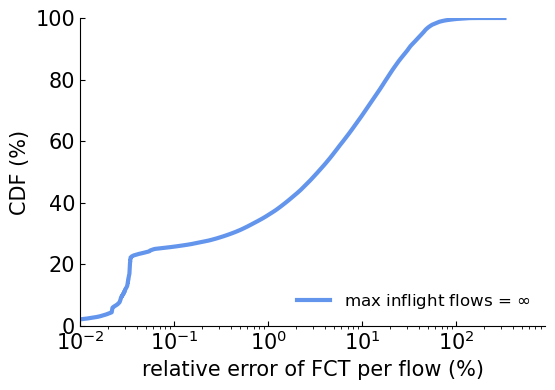

In [12]:
res_error_time=[]
res_error_sldn=[]
max_inflight_flows_list=[0]
flow_size_threshold='inf'
legend_list=[f'max inflight flows = {max_inflight_flows}' if max_inflight_flows!=0 else f'max inflight flows = $\infty$' for max_inflight_flows in max_inflight_flows_list]
for max_inflight_flows in max_inflight_flows_list:
    data = np.load(f'./res/inference_{model_instance}{empirical_str}.npz')
    fct = data['fct']
    sldn = data['sldn']
    print(f"fct: {fct.shape}, sldn: {sldn.shape}")
    
    # Extract the data
    predicted_completion_times = fct[:, :, 0].flatten()
    actual_completion_times = fct[:, :, 1].flatten()
    predicted_sldns = sldn[:, :, 0].flatten()
    actual_sldns = sldn[:, :, 1].flatten()
    print('Predicted Completion Times:', predicted_completion_times.shape)
    # calculate the relative error
    relative_error_time = np.abs(actual_completion_times - predicted_completion_times) / actual_completion_times *100
    relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    res_error_time.append(relative_error_time)
    res_error_sldn.append(relative_error_sldn)
    print(f"max sldn = {np.max(actual_sldns)}, {np.max(predicted_sldns)}")
    print(f"mean error={np.mean(relative_error_time)}, {np.median(relative_error_sldn)}")
    print(f"p99 error")

fig_index=0
plot_cdf(
    res_error_sldn,
    None,
    legend_list,
    x_label="relative error of FCT per flow (%)",
    log_switch=True,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=1,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=fig_index
)
fig_index=1



index_list_ori:94
flowsim-sldn: (94, 80000)
final_param_6-sldn: (94, 80000)
slowdown_list:(2, 2, 94, 80000)
error_list:[114.92666731668476, 79.65260421063651]
error_list:[19.545753606803384, 12.777746389164117]


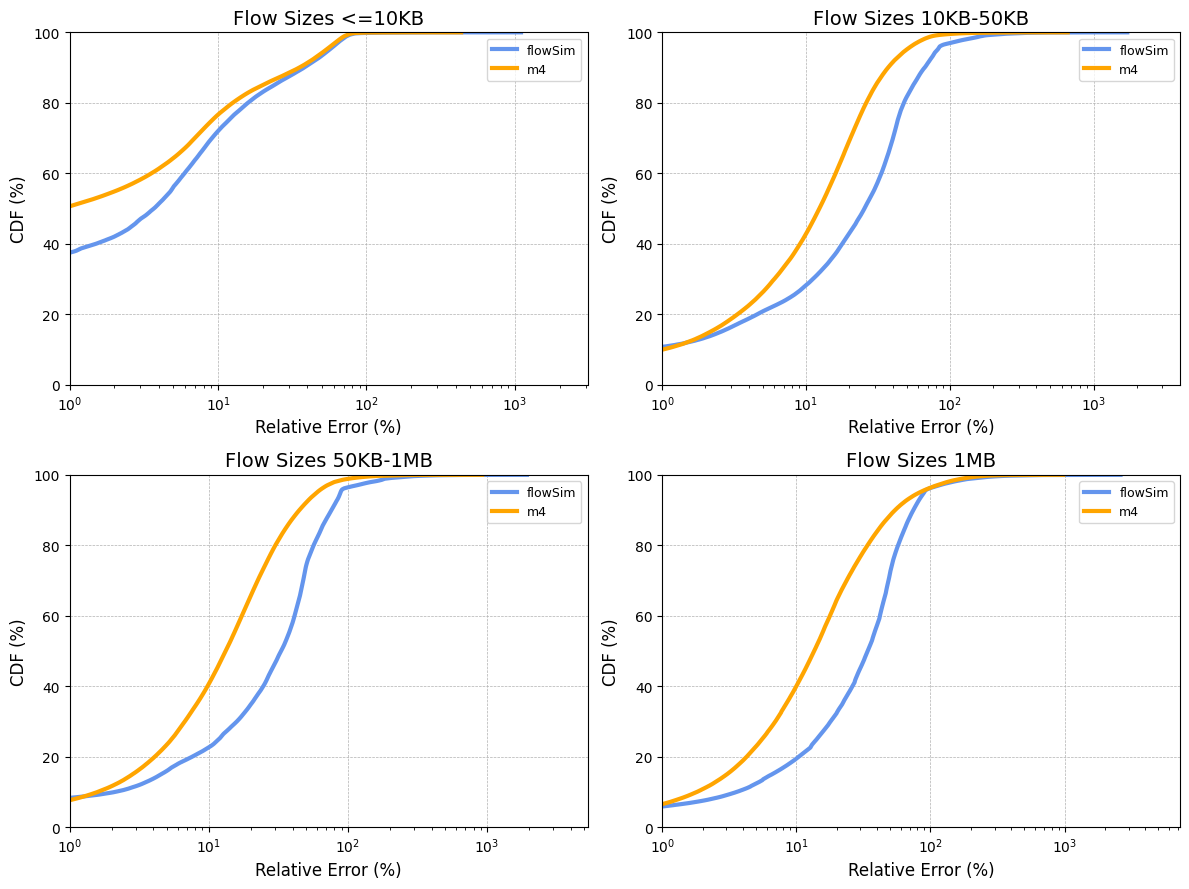

In [3]:
n_scenario=100
empirical_str = "eval_test_8k"
n_flows=80000
legend_list=['flowSim','m4']
model_instance_list=['flowsim','final_param_6']
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
size_list=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        sizes=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/fsize.npy')
        size_tmp=np.zeros(n_flows)
        size_tmp[:len(sizes)]=sizes
        index_list_ori.append(i)
        size_list.append(size_tmp)
size_list=np.array(size_list)
print(f"index_list_ori:{len(index_list_ori)}")
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0]
    size_dist=config['size_dist'].split('/')[-1].split('.')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0]
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma])
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
error_size_list=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['sldn']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns<1]=1
    actual_sldns[actual_sldns<1]=1
    # calculate the relative error
    relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    error_list.append(relative_error_sldn)
    error_size_list.append(size_list[index_list])
config_list=config_list[index_list]
error_list=np.array(error_list)

print(f"error_list:{[np.percentile(x,99) for x in error_list]}")
print(f"error_list:{[np.mean(x) for x in error_list]}")


# Define flow size buckets
size_bins = [0, 10 * 1024, 50 * 1024, 1024 * 1024, np.inf]  # Sizes in bytes
size_bin_labels = ['<=10KB', '10KB-50KB','50KB-1MB', '1MB']

# Initialize a dictionary to store errors per size bucket for each model instance
error_bins = {legend: {label: np.array([]) for label in size_bin_labels} for legend in legend_list}

# Process the data for each model instance
for mi in range(n_methods):
    legend = legend_list[mi]
    errors = error_list[mi]  # Shape: (n_scenarios, n_flows)
    sizes = error_size_list[mi]  # Shape: (n_scenarios, n_flows)

    # Flatten the arrays
    errors_flat = errors.flatten()
    sizes_flat = sizes.flatten()

    # Assign flows to size buckets
    size_indices = np.digitize(sizes_flat, size_bins)

    # Collect errors for each size bucket
    for b in range(1, len(size_bins)):
        bin_mask = size_indices == b
        bin_errors = errors_flat[bin_mask]
        error_bins[legend][size_bin_labels[b - 1]] = np.concatenate((error_bins[legend][size_bin_labels[b - 1]], bin_errors))

# Plot the CDF of errors for each size bucket
plt.figure(figsize=(12, 9))
for idx, size_bin_label in enumerate(size_bin_labels):
    plt.subplot(2, 2, idx + 1)
    for mi, legend in enumerate(legend_list):
        bin_errors = error_bins[legend][size_bin_label]
        if len(bin_errors) > 0:
            # Sort the errors and compute the CDF
            sorted_errors = np.sort(bin_errors)
            yvals = np.arange(1, len(sorted_errors) + 1) / float(len(sorted_errors))
            plt.plot(sorted_errors, yvals * 100, label=legend, color=color_list[mi % len(color_list)], linewidth=3)
    plt.xlabel('Relative Error (%)', fontsize=12)
    plt.ylabel('CDF (%)', fontsize=12)
    plt.title(f'Flow Sizes {size_bin_label}', fontsize=14)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xscale('log')
    plt.legend(fontsize=9)
    plt.xlim(left=1)
    plt.ylim([0, 100])
    plt.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout to prevent overlapping labels and titles
plt.tight_layout()
plt.show()

index_list_ori:94
flowsim-sldn: (94, 5000)
final_param_6-sldn: (94, 5000)


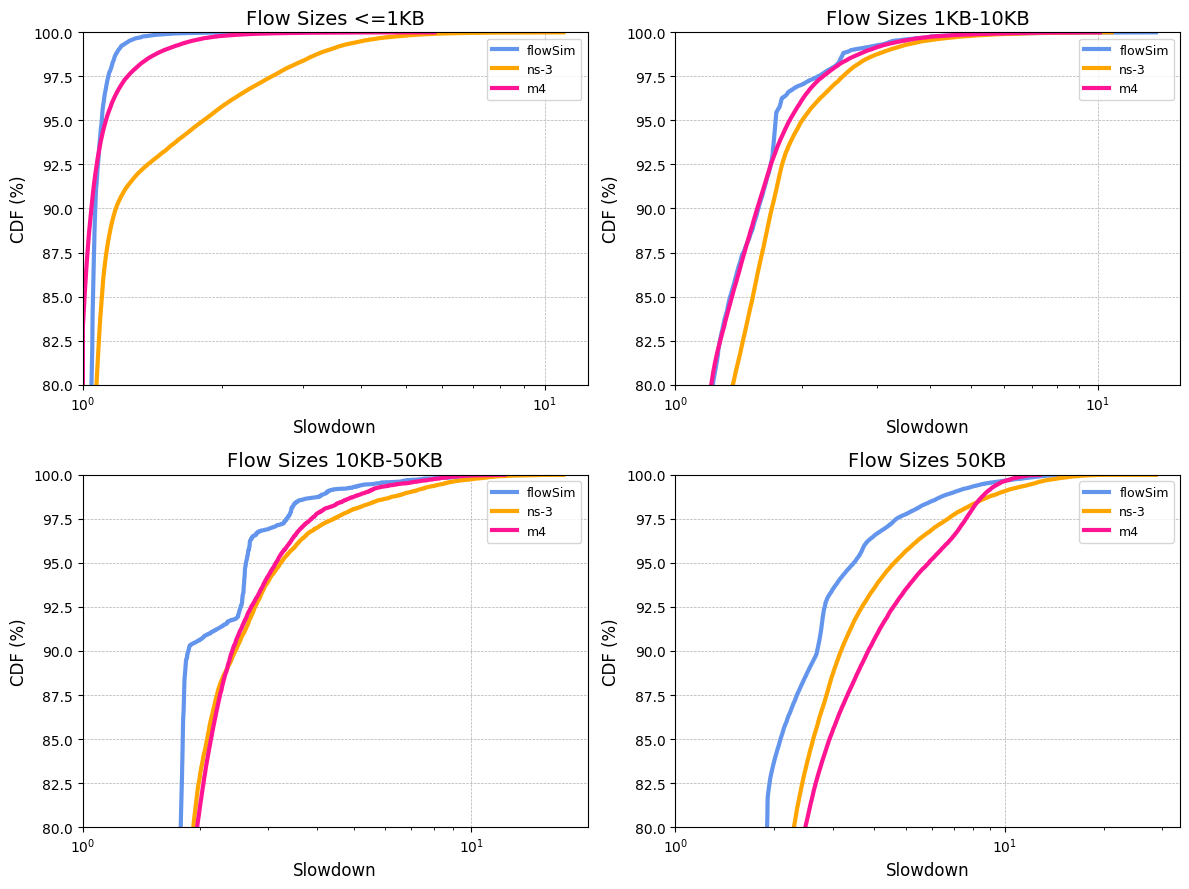

In [66]:
n_scenario=100
empirical_str = "eval_test_8k"
n_flows=5000
legend_list=['flowSim','ns-3','m4']
model_instance_list=['flowsim','final_param_6']
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
size_list=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        sizes=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/fsize.npy')
        sizes=sizes[:n_flows]
        size_tmp=np.zeros(n_flows)
        size_tmp[:len(sizes)]=sizes
        index_list_ori.append(i)
        size_list.append(size_tmp)
size_list=np.array(size_list)
print(f"index_list_ori:{len(index_list_ori)}")
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0]
    size_dist=config['size_dist'].split('/')[-1].split('.')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0]
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma])
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
error_size_list=[]
for model_idx,model_instance in enumerate(model_instance_list):
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['sldn']
    predicted_sldns = sldn[index_list, :n_flows, 0]
    actual_sldns = sldn[index_list,:n_flows, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns<1]=1
    actual_sldns[actual_sldns<1]=1
    # calculate the relative error
    if model_idx==0:
        error_list.extend([predicted_sldns,actual_sldns])
        error_size_list.extend([size_list[index_list],size_list[index_list]])
    else:
        error_list.append(predicted_sldns)
        error_size_list.append(size_list[index_list])
config_list=config_list[index_list]
error_list=np.array(error_list)

# Define flow size buckets
size_bins = [0, 1 * 1024, 50 * 1024, 100 * 1024, np.inf]  # Sizes in bytes
size_bin_labels = ['<=1KB', '1KB-10KB','10KB-50KB', '50KB']

# Initialize a dictionary to store errors per size bucket for each model instance
error_bins = {legend: {label: np.array([]) for label in size_bin_labels} for legend in legend_list}

# Process the data for each model instance
for mi in range(n_methods):
    legend = legend_list[mi]
    errors = error_list[mi]  # Shape: (n_scenarios, n_flows)
    sizes = error_size_list[mi]  # Shape: (n_scenarios, n_flows)

    # Flatten the arrays
    errors_flat = errors.flatten()
    sizes_flat = sizes.flatten()

    # Assign flows to size buckets
    size_indices = np.digitize(sizes_flat, size_bins)

    # Collect errors for each size bucket
    for b in range(1, len(size_bins)):
        bin_mask = size_indices == b
        bin_errors = errors_flat[bin_mask]
        error_bins[legend][size_bin_labels[b - 1]] = np.concatenate((error_bins[legend][size_bin_labels[b - 1]], bin_errors))

# Plot the CDF of errors for each size bucket
plt.figure(figsize=(12, 9))
for idx, size_bin_label in enumerate(size_bin_labels):
    plt.subplot(2, 2, idx + 1)
    for mi, legend in enumerate(legend_list):
        bin_errors = error_bins[legend][size_bin_label]
        if len(bin_errors) > 0:
            # Sort the errors and compute the CDF
            sorted_errors = np.sort(bin_errors)
            yvals = np.arange(1, len(sorted_errors) + 1) / float(len(sorted_errors))
            plt.plot(sorted_errors, yvals * 100, label=legend, color=color_list[mi % len(color_list)], linewidth=3)
    plt.xlabel('Slowdown', fontsize=12)
    plt.ylabel('CDF (%)', fontsize=12)
    plt.title(f'Flow Sizes {size_bin_label}', fontsize=14)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xscale('log')
    plt.legend(fontsize=9)
    plt.xlim(left=1)
    plt.ylim([80, 100])
    plt.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout to prevent overlapping labels and titles
plt.tight_layout()
plt.show()

flowsim-sldn: (1, 85584)
final_param_6-sldn: (1, 85584)


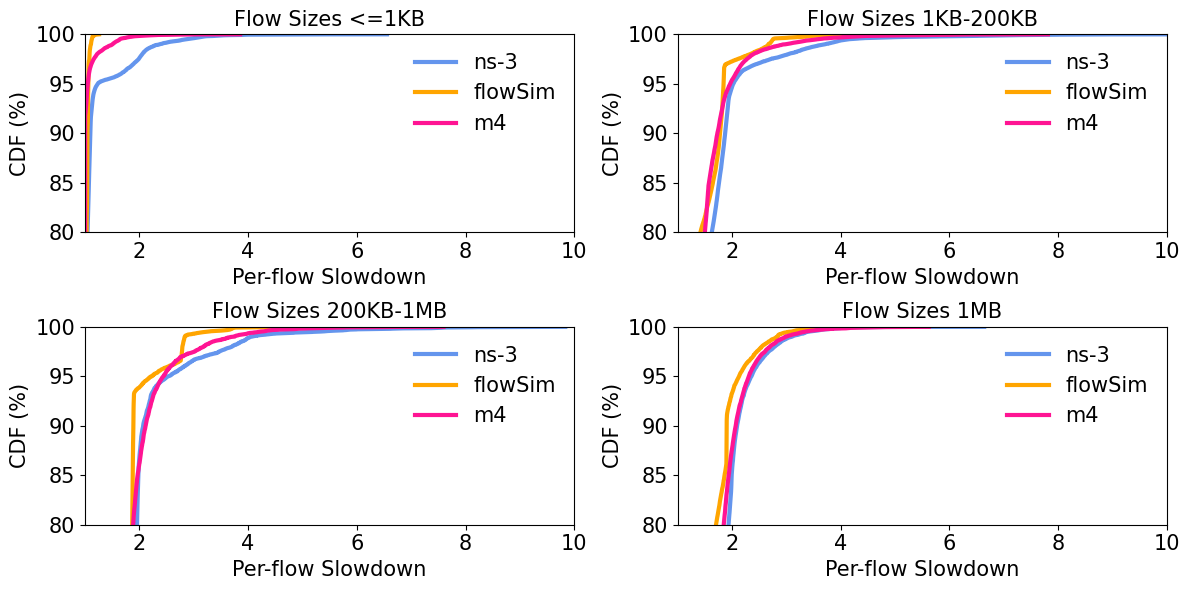

flowsim-sldn: (1, 573200)
final_param_6-sldn: (1, 573200)


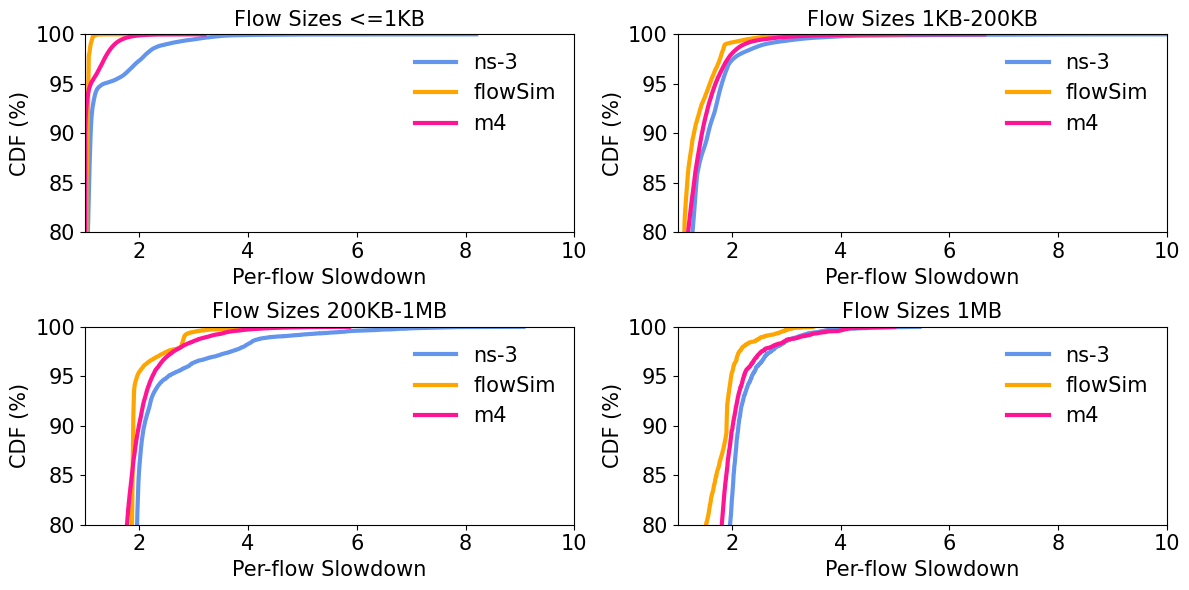

flowsim-sldn: (1, 92278)
final_param_6-sldn: (1, 92278)


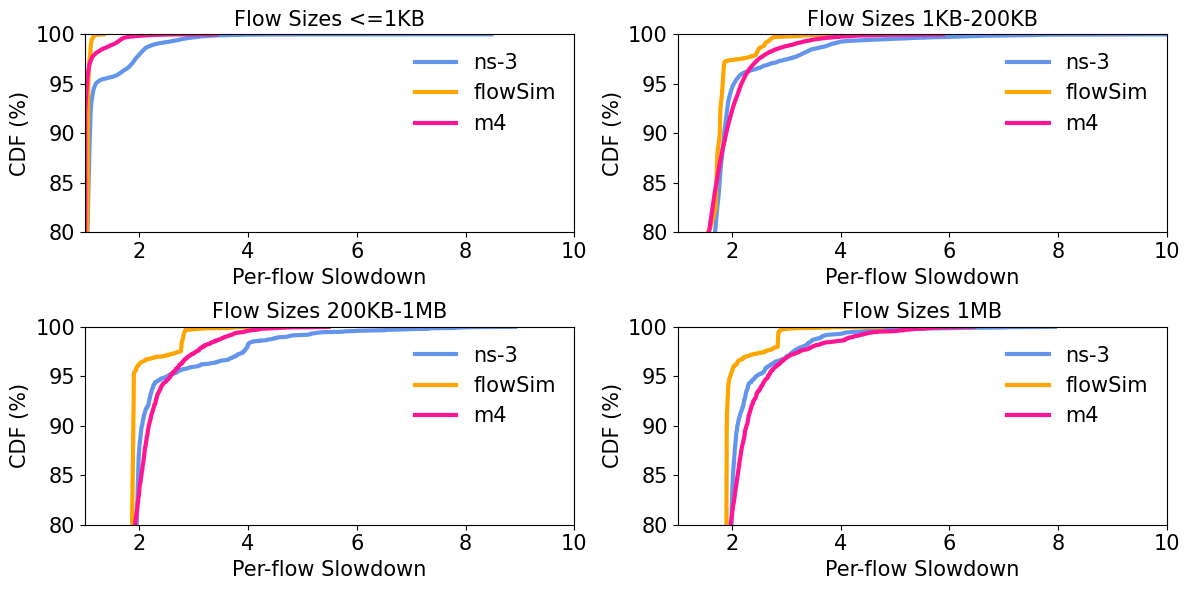

In [39]:
size_bins = [0, 1 * 1024, 200 * 1024, 1024 * 1024, np.inf]  # Sizes in bytes
size_bin_labels = ['<=1KB', '1KB-200KB','200KB-1MB', '1MB']
legend_list=['ns-3','flowSim','m4']
model_instance_list=['flowsim','final_param_6']
n_methods = len(legend_list)
font_size=15
for scenario_idx in range(3):
    empirical_str = f"_large{scenario_idx}"

    sizes=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_7/data/{scenario_idx}/ns3/fsize.npy')

    error_list=[]
    error_size_list=[]
    for model_idx,model_instance in enumerate(model_instance_list):
        data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[:, :, 0]
        actual_sldns = sldn[:,:, 1]
        print(f"{model_instance}-sldn: {predicted_sldns.shape}")
        
        predicted_sldns[predicted_sldns<1]=1
        actual_sldns[actual_sldns<1]=1
        if model_idx==0:
            error_list.extend([actual_sldns,predicted_sldns])
            error_size_list.extend([sizes,sizes])
        else:
            error_list.append(predicted_sldns)
            error_size_list.append(sizes)

    # Initialize a dictionary to store errors per size bucket for each model instance
    error_bins = {legend: {label: np.array([]) for label in size_bin_labels} for legend in legend_list}

    # Process the data for each model instance
    for mi in range(n_methods):
        legend = legend_list[mi]
        errors = error_list[mi]  # Shape: (n_scenarios, n_flows)
        sizes = error_size_list[mi]  # Shape: (n_scenarios, n_flows)

        # Flatten the arrays
        errors_flat = errors.flatten()
        sizes_flat = sizes.flatten()

        # Assign flows to size buckets
        size_indices = np.digitize(sizes_flat, size_bins)

        # Collect errors for each size bucket
        for b in range(1, len(size_bins)):
            bin_mask = size_indices == b
            bin_errors = errors_flat[bin_mask]
            error_bins[legend][size_bin_labels[b - 1]] = np.concatenate((error_bins[legend][size_bin_labels[b - 1]], bin_errors))

    # Plot the CDF of errors for each size bucket
    plt.figure(figsize=(12, 6))
    for idx, size_bin_label in enumerate(size_bin_labels):
        plt.subplot(2, 2, idx + 1)
        for mi, legend in enumerate(legend_list):
            bin_errors = error_bins[legend][size_bin_label]
            if len(bin_errors) > 0:
                # Sort the errors and compute the CDF
                sorted_errors = np.sort(bin_errors)
                yvals = np.arange(1, len(sorted_errors) + 1) / float(len(sorted_errors))
                plt.plot(sorted_errors, yvals * 100, label=legend, color=color_list[mi % len(color_list)], linewidth=3)
        plt.xlabel('Per-flow Slowdown', fontsize=font_size)
        plt.ylabel('CDF (%)', fontsize=font_size)
        plt.title(f'Flow Sizes {size_bin_label}', fontsize=font_size)
        # plt.grid(True, linestyle='--', linewidth=0.5)
        # plt.xscale('log')
        plt.legend(fontsize=font_size,frameon=False)
        plt.xlim(left=1,right=10)
        plt.ylim([80, 100])
        plt.tick_params(axis='both', which='major', labelsize=font_size)

    # Adjust layout to prevent overlapping labels and titles
    plt.tight_layout()
    plt.show()

flowsim-sldn: (68, 2000)
topo_512_flowsim_input_dropout_39-sldn: (68, 2000)
topo_512_flowsim_input_empirical_94-sldn: (68, 2000)
p99 error:[35.40366496442742, 21.289256441422463, 21.181514751645018]
mean error:[15.574792735909815, 8.44375731671126, 7.263871819884394]
median error:[13.704532378169448, 7.070499743332196, 5.752123874762793]


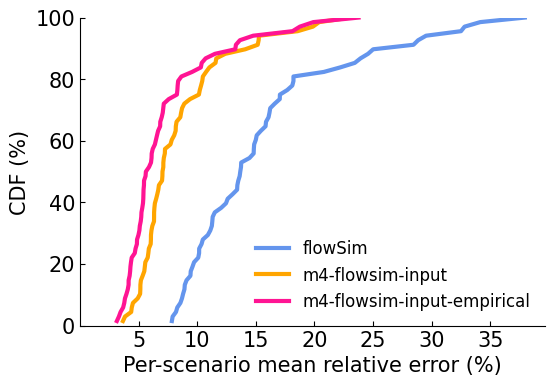

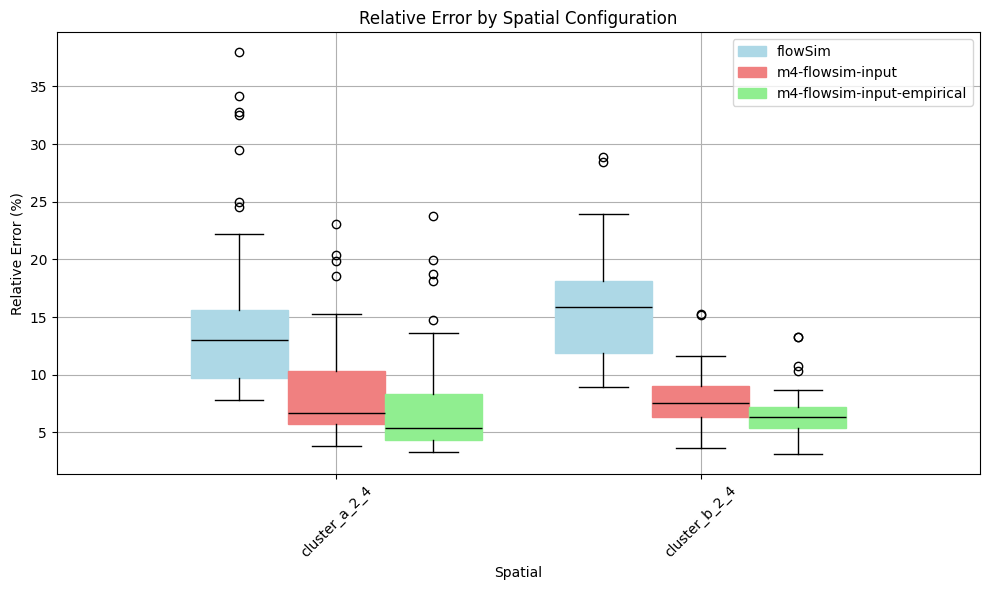

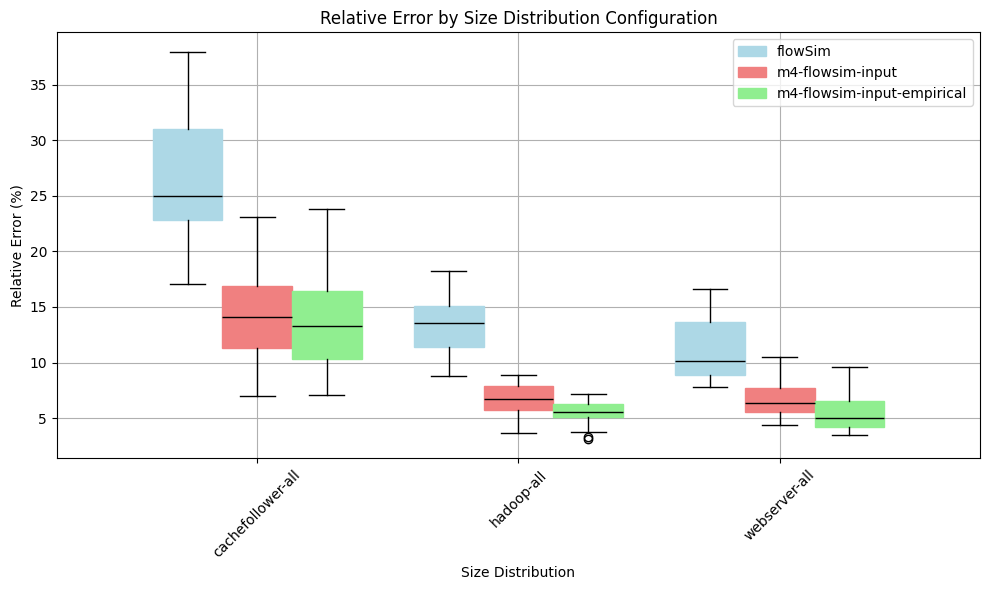

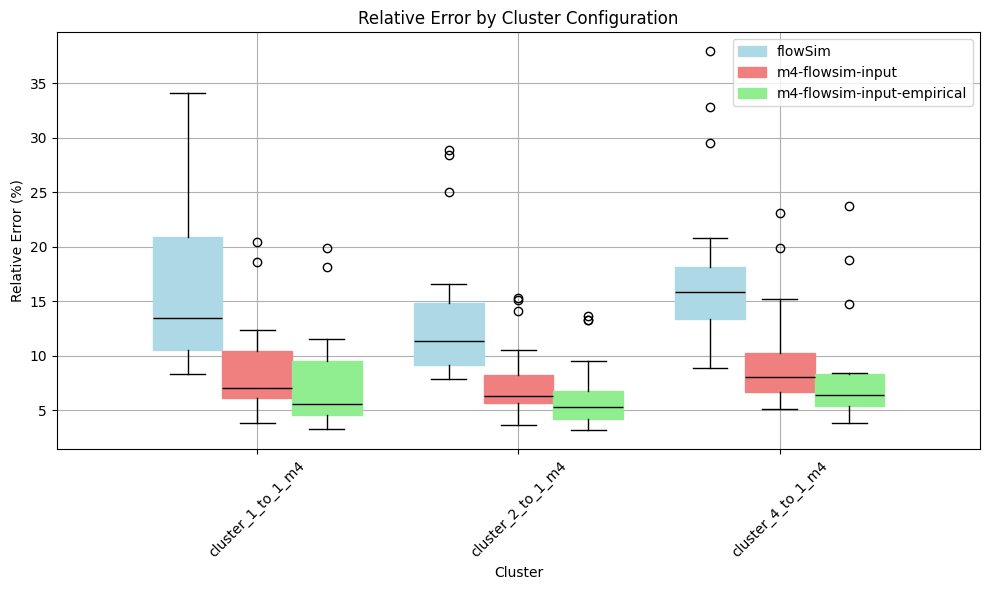

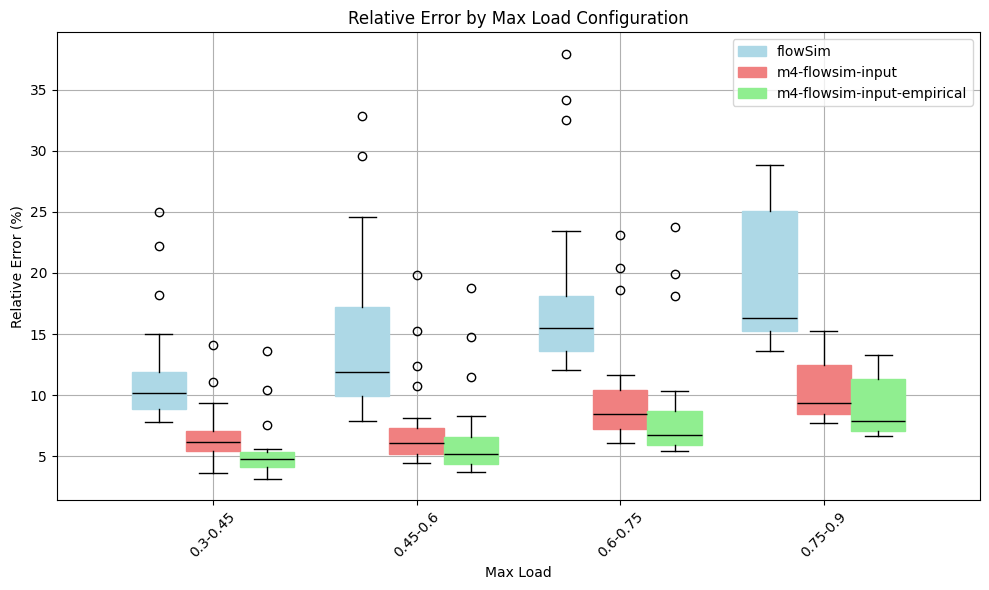

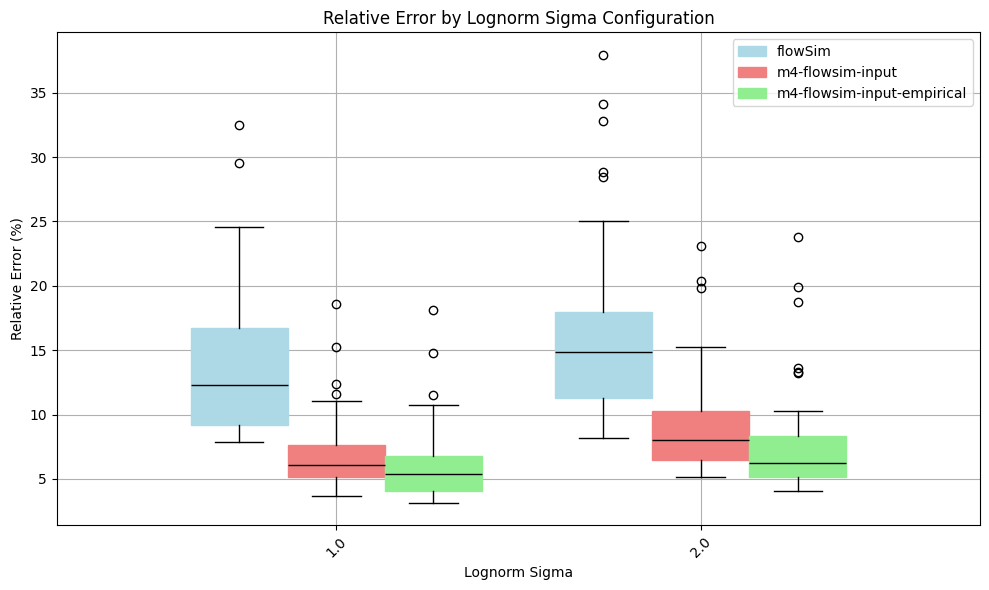

In [4]:
n_scenario=100
empirical_str = "_empirical"
legend_list=['flowSim','m4-flowsim-input','m4-flowsim-input-empirical']
model_instance_list=['flowsim','topo_512_flowsim_input_dropout_39', 'topo_512_flowsim_input_empirical_94']
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/dctcp{empirical_str}.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/data_empirical/{i}/ns3/fid_topology_flows_dctcp.npy'):
        index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0]
    size_dist=config['size_dist'].split('/')[-1].split('.')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0]
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma])
    if spatial!="cluster_c_2_4":
        index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res_dctcp/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns<1]=1
    actual_sldns[actual_sldns<1]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    error_list.append(relative_error_sldn)
config_list=config_list[index_list]
error_list=np.array(error_list)

print(f"p99 error:{[np.percentile(x,99) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")

plot_cdf(
    error_list,
    None,
    legend_list,
    x_label="Per-scenario mean relative error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
)

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)

# Define bins and labels (corrected)
bins = [0.3, 0.45, 0.6, 0.75, 0.9]
labels = ['0.3-0.45', '0.45-0.6', '0.6-0.75', '0.75-0.9']

# Discretize max_load_values
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1

# Assign labels to the discretized values
max_load_labels = [labels[i] for i in max_load_bins]

# Update config_list with discretized max_load labels
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]

# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)


# Function to plot box plots for each configuration type
def plot_box_by_config(error_list, config_list, legend_list, config_index, config_name):
    unique_configs = np.unique(config_list[:, config_index])
    n_methods = len(legend_list)
    
    # Prepare data for each unique configuration type
    data_to_plot = {config_value: [[] for _ in range(n_methods)] for config_value in unique_configs}
    for i, config_value in enumerate(config_list[:, config_index]):
        for j in range(n_methods):
            data_to_plot[config_value][j].append(error_list[i, j])
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    x_positions = np.arange(len(unique_configs))
    box_width = 0.8 / n_methods  # Adjust width based on number of methods
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
    handles = []
    
    for j, method_label in enumerate(legend_list):
        method_data = [data_to_plot[config_value][j] for config_value in unique_configs]
        positions = x_positions - 0.4 + (j + 0.5) * box_width  # Center the boxes
        bp = plt.boxplot(method_data, positions=positions, widths=box_width,
                         patch_artist=True, 
                         boxprops=dict(facecolor=colors[j % len(colors)], color=colors[j % len(colors)]),
                         medianprops=dict(color="black"))
        handles.append(bp["boxes"][0])

    plt.title(f"Relative Error by {config_name} Configuration")
    plt.xlabel(config_name)
    plt.ylabel("Relative Error (%)")
    plt.xticks(x_positions, unique_configs, rotation=45)
    plt.legend(handles, legend_list)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Generate plots for each configuration attribute
config_attributes = ["Spatial", "Size Distribution", "Cluster", "Max Load", "Lognorm Sigma"]
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list.T, config_list, legend_list, config_index=i, config_name=config_name)

flowsim-sldn: (5, 60000)
final_param_6-sldn: (5, 60000)
final_gnn4_7-sldn: (5, 60000)
final_gnn4_6-sldn: (5, 60000)
final_gnn4_5-sldn: (5, 60000)
final_gnn4_4-sldn: (5, 60000)
final_gnn4_3-sldn: (5, 60000)
p99 error:[20.204684254501206, 14.185258394271493, 14.80194423623438, 14.41836200644217, 14.009719177516086, 16.18414436487763, 14.551574844270057]
mean error:[14.769260435696463, 9.854293674108508, 10.383233742878776, 10.747538313197937, 10.877699971585194, 11.154445216713334, 11.87472659738237]
median error:[14.563457669331692, 10.103850586831468, 9.5378523301812, 10.596710935741413, 10.144082198549954, 10.155422371082524, 12.665413203501092]
p99 error:[20.710458003030617, 8.83147566443507, 15.922353282324403, 8.727396151046428, 14.854807923899902, 16.88869251706657, 15.07163796861596]


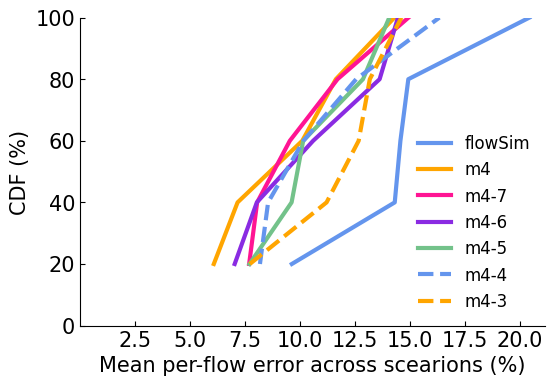

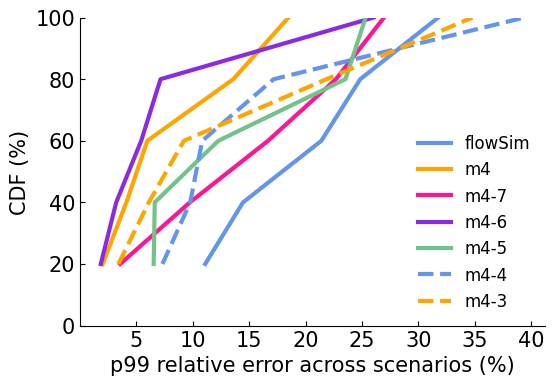

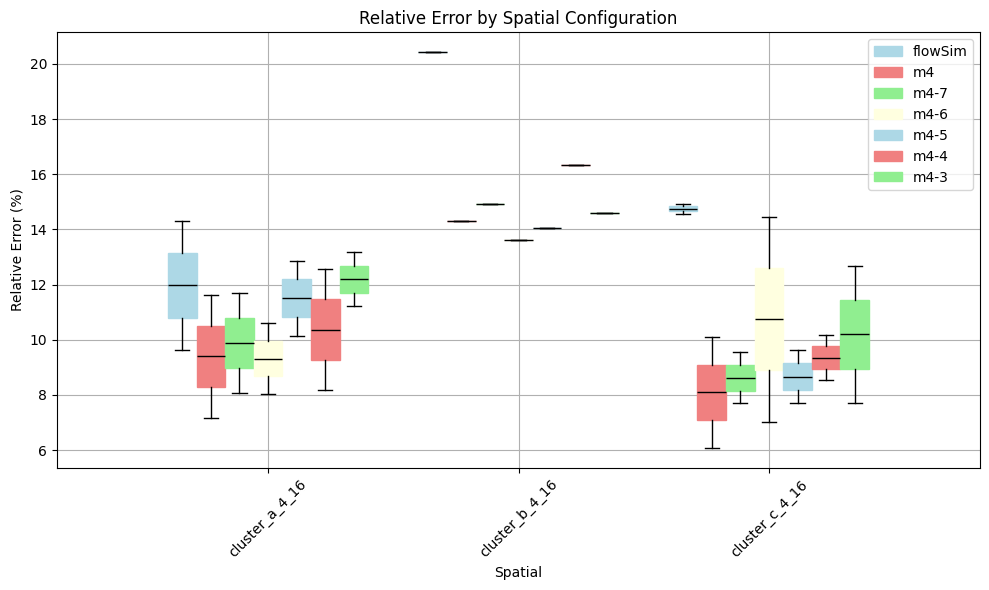

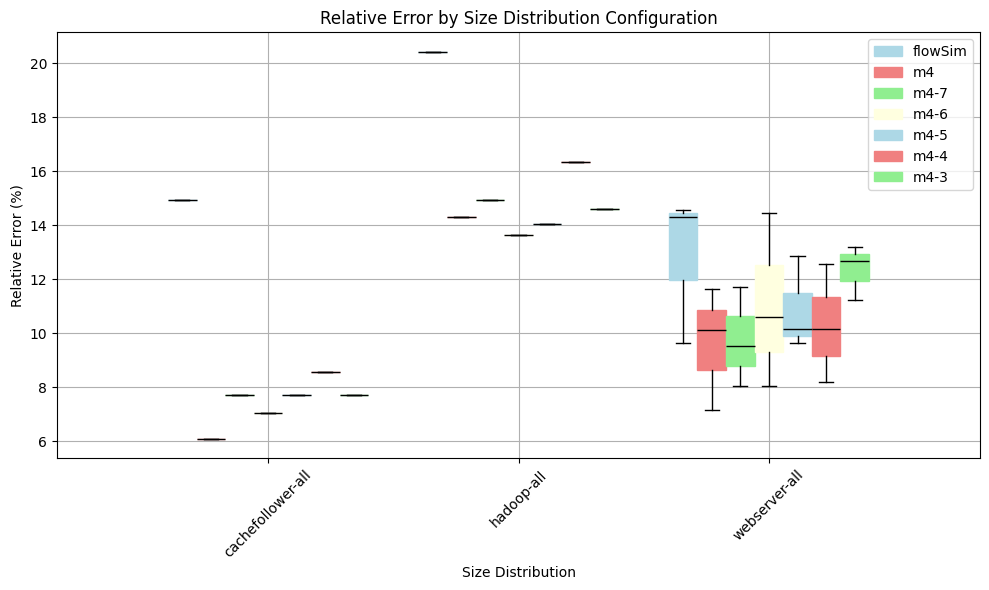

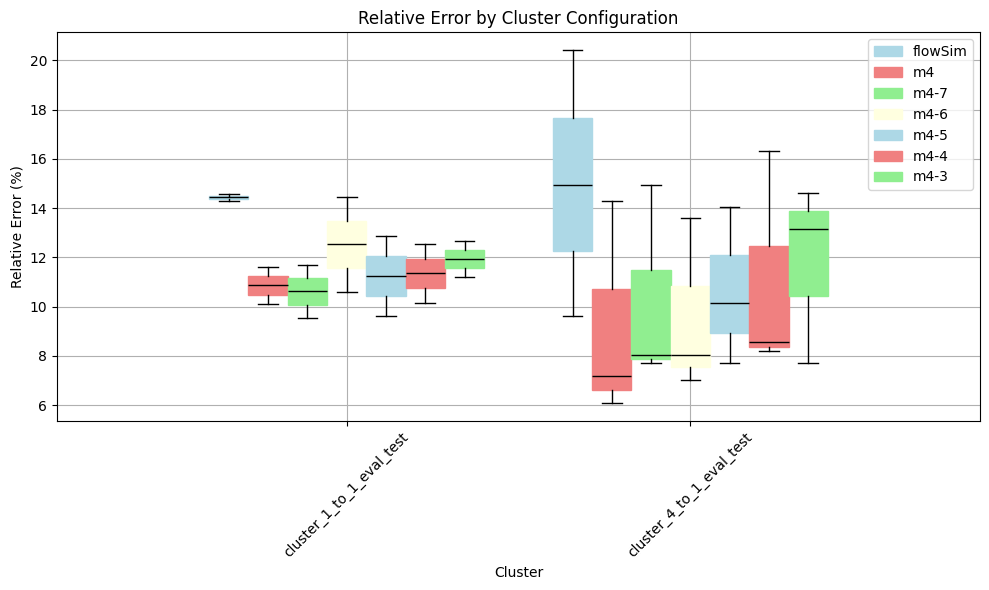

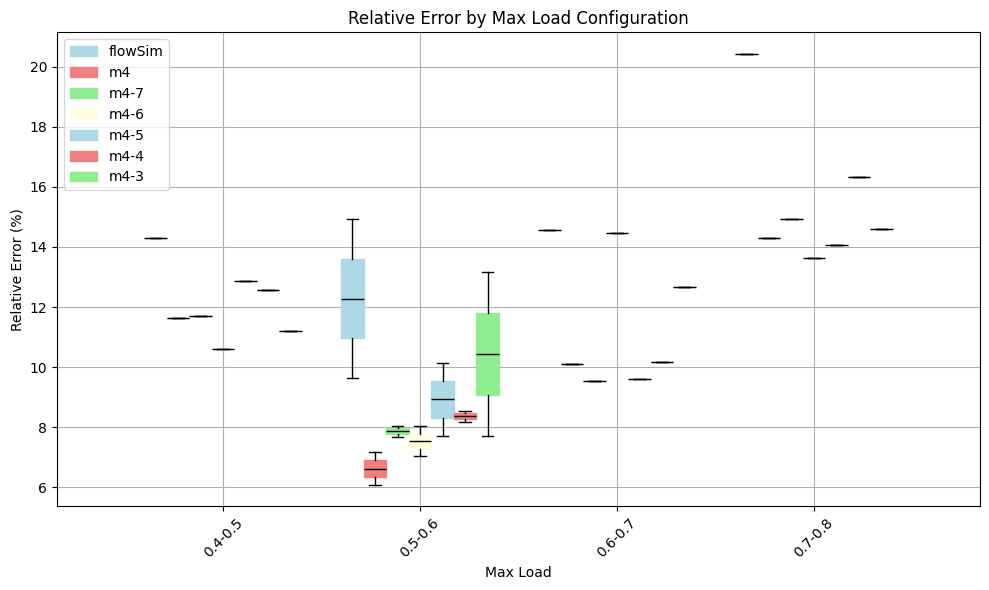

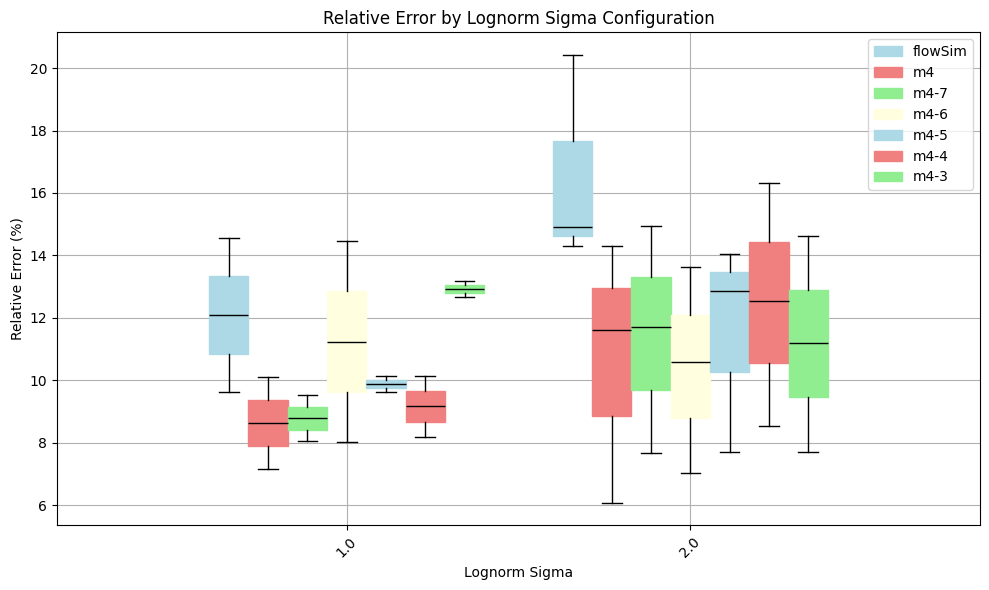

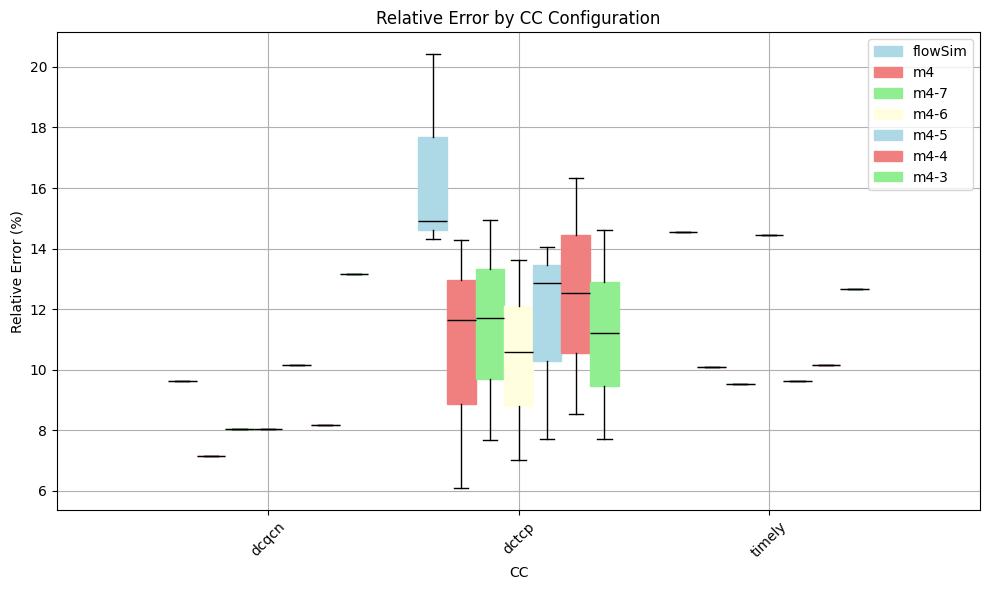

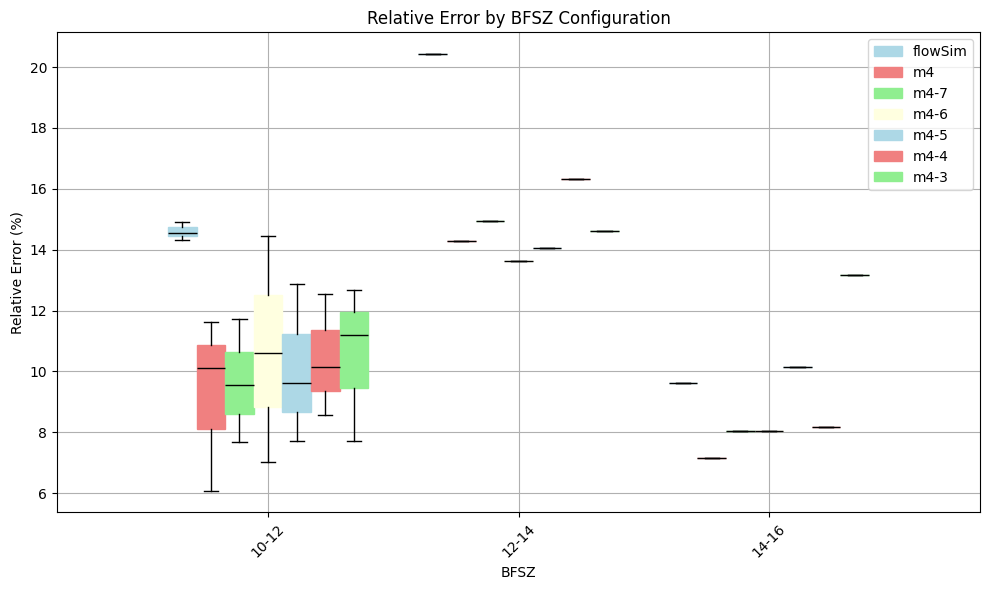

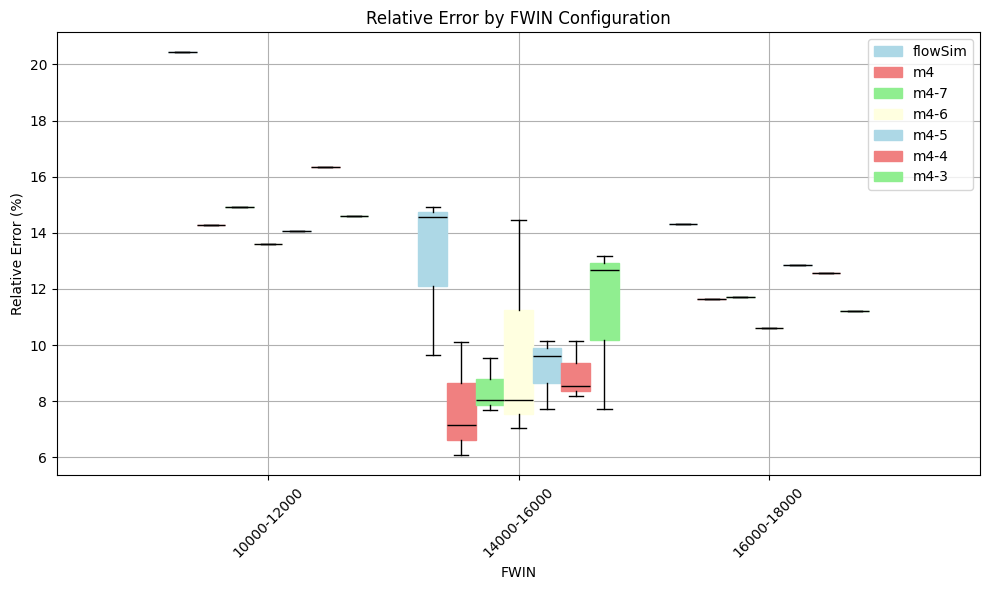

In [50]:
n_scenario=5
empirical_str = "eval_test"
# empirical_str = "eval_test_new_large"
# legend_list=['flowSim','m4-data','m4-7']
# model_instance_list=['flowsim','topo_remainsize_large_data_7','topo_featrate_7']
# legend_list=['flowSim','m4']
# model_instance_list=['flowsim','topo_featrate_7']
# legend_list=['flowSim','m4-pre','m4']
# model_instance_list=['flowsim','topo_featrate_7','final_7']
# legend_list=['flowSim','m4','m4-large-5']
# model_instance_list=['flowsim','final_param_6','final_large_5']
# legend_list=['flowSim','m4']
# model_instance_list=['flowsim','final_param_6']
legend_list=['flowSim','m4','m4-7','m4-6','m4-5','m4-4','m4-3']
model_instance_list=['flowsim','final_param_6','final_gnn4_7','final_gnn4_6','final_gnn4_5','final_gnn4_4','final_gnn4_3']
# legend_list=['flowSim','m4','m4-8','m4-7','m4-6','m4-5','m4-4']
# model_instance_list=['flowsim','final_param_6','final_gnnmean_8','final_gnnmean_7','final_gnnmean_6','final_gnnmean_5','final_gnnmean_4']
                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0]
    size_dist=config['size_dist'].split('/')[-1].split('.')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0]
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc']
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
    # if spatial!="cluster_c_4_16":
    # if size_dist!='webserver-all':
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
config_list=config_list[index_list]
error_list=np.array(error_list)
error_list_p99=np.array(error_list_p99)

print(f"p99 error:{[np.percentile(x,99) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")
print(f"p99 error:{[np.mean(x) for x in error_list_p99]}")

plot_cdf(
    error_list,
    None,
    legend_list,
    x_label="Mean per-flow error across scearions (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=0,
)

plot_cdf(
    error_list_p99,
    None,
    legend_list,
    x_label="p99 relative error across scenarios (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=1,
)

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)
bins = [0.3, 0.4,0.5, 0.6, 0.7, 0.8]
labels = ['0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8']
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1
max_load_labels = [labels[i] for i in max_load_bins]
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]
    
bfsz_values = np.array([config[6] for config in config_list], dtype=float)
bins = [10,12,14,16,18,20]
labels = ['10-12', '12-14', '14-16', '16-18', '18-20']
bfsz_bins = np.digitize(bfsz_values, bins, right=False) - 1
bfz_labels = [labels[i] for i in bfsz_bins]
for idx, config in enumerate(config_list):
    config[6] = bfz_labels[idx]

fwin_values=np.array([config[7] for config in config_list], dtype=float)
bins = [10000,12000,14000,16000,18000,20000]
labels = ['10000-12000', '12000-14000', '14000-16000', '16000-18000', '18000-20000']
fwin_bins = np.digitize(fwin_values, bins, right=False) - 1
fwin_labels = [labels[i] for i in fwin_bins]
for idx, config in enumerate(config_list):
    config[7] = fwin_labels[idx]
# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)


# Function to plot box plots for each configuration type
def plot_box_by_config(error_list, config_list, legend_list, config_index, config_name):
    unique_configs = np.unique(config_list[:, config_index])
    n_methods = len(legend_list)
    
    # Prepare data for each unique configuration type
    data_to_plot = {config_value: [[] for _ in range(n_methods)] for config_value in unique_configs}
    for i, config_value in enumerate(config_list[:, config_index]):
        for j in range(n_methods):
            data_to_plot[config_value][j].append(error_list[i, j])
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    x_positions = np.arange(len(unique_configs))
    box_width = 0.8 / n_methods  # Adjust width based on number of methods
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
    handles = []
    
    for j, method_label in enumerate(legend_list):
        method_data = [data_to_plot[config_value][j] for config_value in unique_configs]
        positions = x_positions - 0.4 + (j + 0.5) * box_width  # Center the boxes
        bp = plt.boxplot(method_data, positions=positions, widths=box_width,
                         patch_artist=True, 
                         boxprops=dict(facecolor=colors[j % len(colors)], color=colors[j % len(colors)]),
                         medianprops=dict(color="black"))
        handles.append(bp["boxes"][0])

    plt.title(f"Relative Error by {config_name} Configuration")
    plt.xlabel(config_name)
    plt.ylabel("Relative Error (%)")
    plt.xticks(x_positions, unique_configs, rotation=45)
    plt.legend(handles, legend_list)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Generate plots for each configuration attribute
config_attributes = ["Spatial", "Size Distribution", "Cluster", "Max Load", "Lognorm Sigma", "CC", "BFSZ", "FWIN"]
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list.T, config_list, legend_list, config_index=i, config_name=config_name)

flowsim_large0-sldn: (85584,)
p99 slowdown: 2.70716249702616, 3.3371159918619004
final_param_6_large0-sldn: (85584,)
p99 slowdown: 2.8636061501502987, 3.3371159918619004
mean error:[19.796066156243874, 7.833949240901469]
p99 error: [18.87718306 14.18919339]


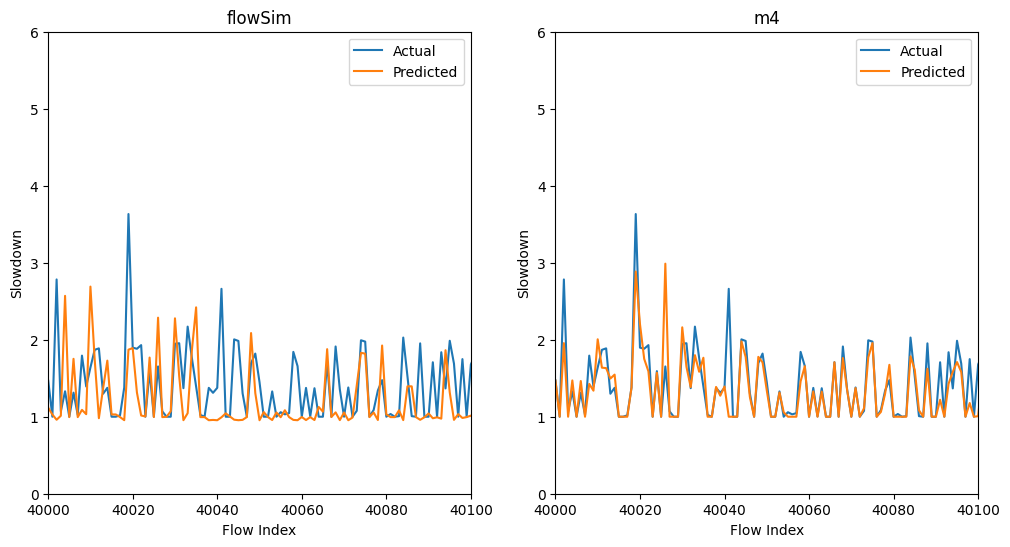

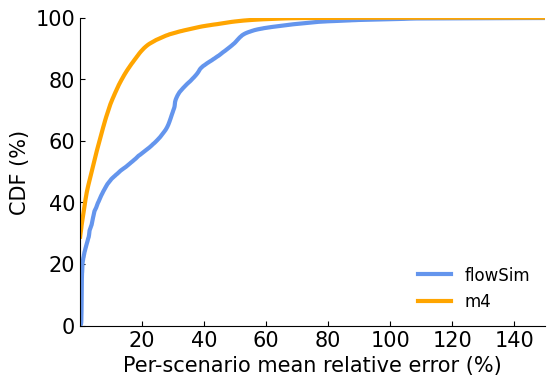

In [26]:
empirical_str = ""
scenario_str="_large0"
# scenario_str=""
# legend_list=['flowSim','m4-flowsim-input','m4-final']
# model_instance_list=[f'flowsim{scenario_str}', f'topo_512_flowsim_input_dropout_19{scenario_str}',f'topo_reprod_19{scenario_str}']
# legend_list=['flowSim','m4','m4-data']
# model_instance_list=[f'flowsim{scenario_str}', f'topo_featrate_7{scenario_str}', f'topo_remainsize_large_data_7{scenario_str}']
# legend_list=['flowSim','m4-pre','m4']
# model_instance_list=[f'flowsim{scenario_str}', f'topo_featrate_7{scenario_str}',f'final_7{scenario_str}']
# legend_list=['flowSim','m4','m4-param']
# model_instance_list=[f'flowsim{scenario_str}',f'final_7{scenario_str}',f'final_param_6{scenario_str}']
legend_list=['flowSim','m4']
model_instance_list=[f'flowsim{scenario_str}',f'final_param_6{scenario_str}']
                     
error_list=[]
error_list_p99=[]
sldn_list=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['sldn']
    predicted_sldns = sldn[:, :, 0].squeeze()
    actual_sldns = sldn[:,:, 1].squeeze()
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_list.append([actual_sldns,predicted_sldns])
    error_list.append(relative_error_sldn)
    
    sldn_p99_est=np.percentile(predicted_sldns,99)
    sldn_p99_act=np.percentile(actual_sldns,99)
    print(f"p99 slowdown: {sldn_p99_est}, {sldn_p99_act}")
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
error_list=np.array(error_list)
error_list_p99=np.array(error_list_p99)
sldn_list=np.array(sldn_list)
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"p99 error: {error_list_p99}")
      
# Plotting
fig, axes = plt.subplots(1, len(model_instance_list), figsize=(12, 6))

# Plot each method in a subfigure
for i, (actual, predicted) in enumerate(sldn_list):
    axes[i].plot(actual, label="Actual")
    axes[i].plot(predicted, label="Predicted")
    axes[i].set_title(legend_list[i])
    axes[i].set_xlabel("Flow Index")
    axes[i].set_ylabel("Slowdown")
    axes[i].legend()
    axes[i].set_xlim(40000, 40100)
    axes[i].set_ylim(0, 6)
plot_cdf(
    error_list,
    None,
    legend_list,
    x_label="Per-scenario mean relative error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=200,
    xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
)

ns-3: 94
m4: 94
ns-3: 2907.9704255319148, m4: 241.19317416941865, flowsim: 56.40186381340027


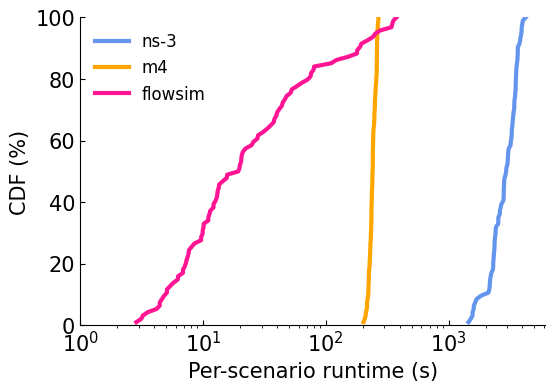

In [25]:
import re
n_scenario=100
empirical_str='eval_test_8k'
data_root="/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8"
legend_list=['ns-3', 'm4', 'flowsim']
res=[]

time_ns3=[]
'''
for i in range(n_scenario):
    if os.path.exists(f'{data_root}/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        time_file=f'{data_root}/{empirical_str}/{i}/ns3/elapsed.txt'
        with open(time_file, "r") as file:
            number = float(file.read().strip())
            time_ns3.append(number)
res.append(time_ns3)     
print(f"ns-3: {len(time_ns3)}")  
'''

with open(f'{data_root}/{empirical_str}/ns3_times.txt') as f:
    time_ns3 = [float(txt.replace("\n", "")) for txt in f.readlines()]

print(f"ns-3: {len(time_ns3)}")  
res.append(time_ns3)

def read_log_file(file_path):
    try:
        with open(file_path, 'r') as file:
            log_text = file.read()
        return log_text
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        return None

def extract_scenario_times(log_text):
    # Regex patterns for time elapsed and workload scenario
    time_pattern = r"Time elapsed:\s([\d.]+)"

    # Extract times and workload IDs
    elapsed_times = re.findall(time_pattern, log_text)

    # Create a dictionary mapping scenario ID to time elapsed
    scenario_times = []
    for workload_idx, time in enumerate(elapsed_times):
        time=float(time)
        scenario_times.append(float(time))
    
    return scenario_times

log_text = read_log_file(f'{empirical_str}.log')
time_m4 = extract_scenario_times(log_text)
res.append(time_m4)
print(f"m4: {len(time_m4)}")

with open(f'{data_root}/{empirical_str}/flowsim_times.txt') as f:
    flowsim_times = [float(txt.replace("\n", "")) for txt in f.readlines()]

res.append(flowsim_times)

res=np.array(res)
print(f"ns-3: {np.mean(res[0])}, m4: {np.mean(res[1])}, flowsim: {np.mean(res[2])}")

fig_index=0
plot_cdf(
    res,
    None,
    legend_list,
    x_label="Per-scenario runtime (s)",
    log_switch=True,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=1,
    fontsize=15,
    legend_font=12,
    loc=2,
    enable_abs=True,
    group_size=5,
    fig_idx=fig_index
)
fig_index=1